
### Histopathology SCAN MODEL


---

Imports 

---


In [1]:
import importlib
import pipeline as pl
importlib.reload(pl)
import model as ml
importlib.reload(ml)

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras_tuner
from kerastuner.tuners import Hyperband

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.19.0


C:\Users\ckell\AppData\Local\Temp\ipykernel_25892\1512335882.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


---

Load Augmented data from pipeline

---

In [2]:
csv_path = "Histopathology.csv"
train, test,val = pl.loadprocesseddata(csv_path)

Found 45001 validated image filenames belonging to 12 classes.
Found 7500 validated image filenames belonging to 12 classes.
Found 7501 validated image filenames belonging to 12 classes.


---

Build Model

---

In [3]:
def build_cnn_model(hp, n_classes=12):
    activation = hp.Choice("activation", values=["relu", "tanh", "elu"])
    n_conv_layers = hp.Int("n_conv_layers", min_value=2, max_value=5, step=1)
    n_filters = hp.Int("n_filters", min_value=8, max_value=64, step=8)
    
    kernel_size_val = hp.Choice("kernel_size", values=[3, 5])
    pool_size_val = hp.Choice("pool_size", values=[2,3])
    
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=1000, max_value=10000, step=1000)
    decay_rate = hp.Float("decay_rate", min_value=0.9, max_value=0.999, step=0.001)
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)
    batch_norm = hp.Choice("batch_norm", values=[True, False])
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "RMSprop", "adam", "AdamW"])
    
    expon_dec = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    if optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=expon_dec)
    elif optimizer_choice == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=expon_dec)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=expon_dec)
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=n_filters,
        kernel_size=(kernel_size_val, kernel_size_val),
        activation=activation,
        input_shape=(64, 64, 3),
        padding='same'
    ))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val),padding="same"))
    
    for i in range(n_conv_layers - 1):
        model.add(layers.Conv2D(
            filters=n_filters * (2**i),
            kernel_size=(kernel_size_val, kernel_size_val),
            activation=activation,
            padding='same'
        ))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val), padding="same"))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.GlobalAveragePooling2D())
    
    n_dense_units = hp.Int("n_dense_units", min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=n_dense_units, activation=activation))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(n_classes, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


---

Hyperband Search

---

In [4]:
tuner = Hyperband(
    lambda hp: build_cnn_model(hp),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='hyperbanding-ScanTypes',
    project_name='Hist')

Reloading Tuner from hyperbanding-ScanTypes\Hist\tuner0.json


In [5]:
tuner.search(train, epochs=10, validation_data=val)

Trial 30 Complete [00h 40m 39s]
val_accuracy: 0.23196907341480255

Best val_accuracy So Far: 0.8136248588562012
Total elapsed time: 1d 04h 41m 47s


In [7]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 17 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


---

Train Best Model

---

In [6]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True)

In [8]:
history = best_model.fit(
    train,
    epochs=200,
    validation_data=val,
    callbacks=[early_stopping])

Epoch 1/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 169s 119ms/step - accuracy: 0.7765 - loss: 0.5887 - val_accuracy: 0.7504 - val_loss: 0.7704
Epoch 2/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 166s 118ms/step - accuracy: 0.7783 - loss: 0.5725 - val_accuracy: 0.8186 - val_loss: 0.4538
Epoch 3/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 161s 114ms/step - accuracy: 0.7810 - loss: 0.5692 - val_accuracy: 0.7484 - val_loss: 0.7831
Epoch 4/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 162s 114ms/step - accuracy: 0.7812 - loss: 0.5778 - val_accuracy: 0.8347 - val_loss: 0.4469
Epoch 5/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 161s 114ms/step - accuracy: 0.7813 - loss: 0.5748 - val_accuracy: 0.7526 - val_loss: 0.6110
Epoch 6/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 162s 114ms/step - accuracy: 0.7909 - loss: 0.5533 - val_accuracy: 0.7683 - val_loss: 0.6367
Epoch 7/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 161s 114ms/step - accuracy: 0.7874 - loss: 0.5689 - val_accuracy: 0.7775 - val_loss: 0.6921
Epoch 8/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 174s 123ms/s

---

Plot Learning Curve

---

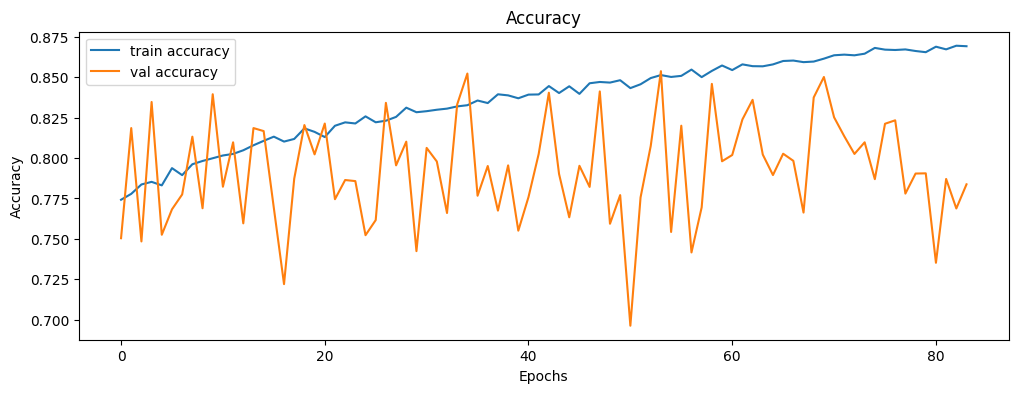

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

Obtain Model Metrics

---

In [10]:
y_pred = best_model.predict(test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test.classes
results = classification_report(y_true, y_pred_classes)
print(results)


235/235 ━━━━━━━━━━━━━━━━━━━━ 71s 305ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       625
           1       0.89      0.82      0.86       625
           2       0.93      0.94      0.93       625
           3       0.95      0.97      0.96       625
           4       0.87      0.93      0.90       625
           5       0.98      1.00      0.99       625
           6       0.95      0.87      0.90       625
           7       0.93      0.67      0.78       625
           8       0.76      0.98      0.85       625
           9       0.78      0.78      0.78       625
          10       0.92      0.39      0.55       625
          11       0.60      0.92      0.73       625

    accuracy                           0.85      7500
   macro avg       0.87      0.85      0.84      7500
weighted avg       0.87      0.85      0.84      7500



---

Obtain Val Accuracy

---

In [ ]:
results = best_model.evaluate(val, verbose=1)
print(f"Metrics: {results[1:]}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.8501 - loss: 0.4165
Metrics: [0.847599983215332]


---

Save the Model

---

In [12]:
best_model.save('Histopathology.keras')
